# **Medical Cost Prediction --- Can we accurately predict medical costs based on people’s data?**

## Introduction

Health issues can arise suddenly and unexpectedly, leading to a lot of stress for those affected. Financial stress is a big part of that; healthcare in the United States is expensive, and an issue can quickly leave a person or family running low on money. Insurance companies exist to mitigate these concerns by using financial capital to reimburse those who find themselves in such a scenario (1, 2). However, insurance companies need to collect more than they spend on the medical care of their beneficiaries to not lose money themselves. To do that, they use historical data to sufficiently and precisely measure the amount of the medical costs covered by the insurance charges of each beneficiary (1, 2). The medical insurers' main job is to correctly anticipate insurance policy costs, develop accurate pricing models, plan a particular insurance outcome, and manage an extensive portfolio based on their data analysis of individual insurance records (1).

Our dataset "Insurance.csv" is taken from Kaggle, and it contains 1,339 insurance records from the past, including age, gender, family status, Body Mass Index, smoking or not, etc. We will train a multiple linear regression model that generates the target individual medical charges more accurately with various factors influencing an individual's health status as model inputs. Additionally, we will determine what the most correlated variables influencing insurance costs are. Our final objective is to predict insurance charges based on our fitted model from the training set using the test set. According to our results, the insurance company can then set the price of yearly premiums higher or lower.

In [63]:
library(tidyverse)
library(repr)
library(digest)
library(infer)
library(cowplot)
library(broom)
library(GGally)
library(car)
library(janitor)
library(scales)
library(car)
library(glmnet)
library(Metrics)
library(class)
library(caret)

In [64]:
data<- read.csv("https://raw.githubusercontent.com/Zibo-S/STAT301_GP_4/main/insurance.csv", header= TRUE)

The variables of interest are described as followings:

age: age of primary beneficiary

sex: insurance contractor gender, female or male

bmi: Body mass index, a measure of body size that is calculated by dividing your weight in kilograms by the square of your height in metres. This calculation is a simple way of checking if a person may have weight-related health problems such as obesity. A healthy BMI is between 18.5 and 24.9 (kg/m^2).

children: Number of children covered by health insurance / Number of dependents, usually from 0-5

smoker: indicates whether or not a person smokes

region: the beneficiary residential area within the US, northeast, southeast, southwest, northwest.

charges: Individual medical costs billed by health insurance, in US dollars.

In [65]:
data%>%head(3)

,age,sex,bmi,children,smoker,region,charges
,<int>,<chr>,<dbl>,<int>,<chr>,<chr>,<dbl>
1,19,female,27.90,0,yes,southwest,16884.924
2,18,male,33.77,1,no,southeast,1725.552
3,28,male,33.00,3,no,southeast,4449.462


## Methods and Results

We plan to use LASSO to fit a linear regression to predict the charges someone might have to pay given different parameters. Because we are using LASSO(3) to find the most accurate model, we do not know what these parameters will be, but we know that they will be a subset of the ones mentioned earlier.

We also compare the LASSO model with Ordinary Least Squares (OLS) model, ridge model and KNN model. We then quantify the models' performance by calculating the root mean squared error (RMSE) that they achieve on the training set. With this, we expect to achieve a model capable of predicting the charges of a patient, which can give more insight into what factors influence charges the most and allow patients to predict the average price that they might have to pay for a visit to the hospital.

Before we do anything, we first want to explore the data that we have available.

#### 1. Split data into training and testing sets (70% vs 30%)

In [66]:
# split data into training and testing sets
set.seed(1234)

data$ID <- 1:nrow(data)
training_set <- sample_n(data, size = nrow(data) * 0.70,
  replace = FALSE
)

testing_set <- anti_join(data,
  training_set,
  by = "ID"
)

head(training_set, 3)
nrow(training_set)

head(testing_set, 3)
nrow(testing_set)

,age,sex,bmi,children,smoker,region,charges,ID
,<int>,<chr>,<dbl>,<int>,<chr>,<chr>,<dbl>,<int>
1,32,male,28.12,4,yes,northwest,21472.479,1308
2,26,female,34.20,2,no,southwest,3987.926,1018
3,23,female,42.75,1,yes,northeast,40904.200,1125


[1] 936

,age,sex,bmi,children,smoker,region,charges,ID
,<int>,<chr>,<dbl>,<int>,<chr>,<chr>,<dbl>,<int>
1,28,male,33.00,3,no,southeast,4449.462,3
2,32,male,28.88,0,no,northwest,3866.855,5
3,37,female,27.74,3,no,northwest,7281.506,8


[1] 402

Check data balancing for our target variable Charges by histogram.

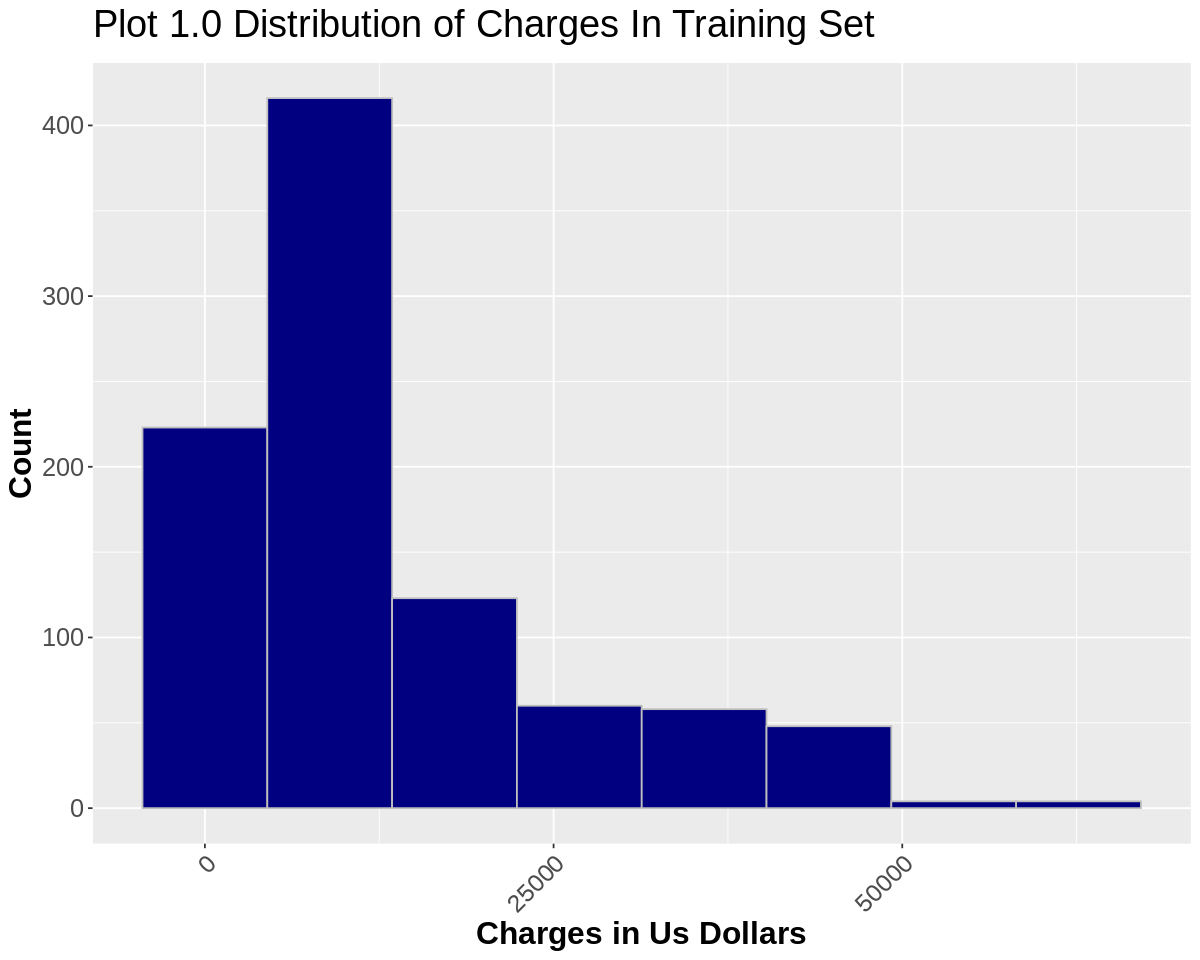

In [67]:
options(repr.plot.width = 10, repr.plot.height = 8)
hist_charges <- ggplot(training_set, aes(x = charges)) +
  geom_histogram(bins = 8, color = "gray", fill = "navyblue") +
  xlab("Charges in Us Dollars") +
  ylab("Count") +
  theme(
    text = element_text(size = 19),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold"),
    axis.text.x = element_text(angle = 45, hjust = 1)
  )+ 
  ggtitle(expression("Plot 1.0 Distribution of Charges In Training Set"))
hist_charges

As we can see, there are less count for chargers over $25000, which make sense, since less people are being charged for higher amount.

#### 2. Perform Data tranformation to the training dataset

In this project, a `log-transformation` is performed to all the numeric variables, for the purpose of reduces or removes the skewness of our training data.<br>
Since glmnet cannot handle categorical variables directly, transferring categorical variables to a binary representation. 

In [68]:
# drop feature 'ID' since it is irrelevant to our target
training_set=training_set[-8]

In [69]:
# log the charge 
tran_training_set<- training_set %>% mutate(sex = factor(sex),
                                            smoker = factor(smoker),
                                            region = factor(region),
                                            charges = log(charges)
                                           )
# 0 for female and 1 for male
levels(tran_training_set$sex) <- c(0,1)

# 1 for yes and 0 for no
levels(tran_training_set$smoker) <- c(0,1)

# northeast = 0, northwest = 1,southeast = 2, southwest = 3, 
levels(tran_training_set$region) <- c(0,1,2,3)

tran_training_set%>%head(5)

,age,sex,bmi,children,smoker,region,charges
,<int>,<fct>,<dbl>,<int>,<fct>,<fct>,<dbl>
1,32,1,28.12,4,1,1,9.974527
2,26,0,34.20,2,0,3,8.291027
3,23,0,42.75,1,1,0,10.618988
4,48,1,29.60,0,0,3,9.963273
5,49,0,21.30,1,0,3,9.125019


Check data balancing again using transfered target variable Charges by histogram.

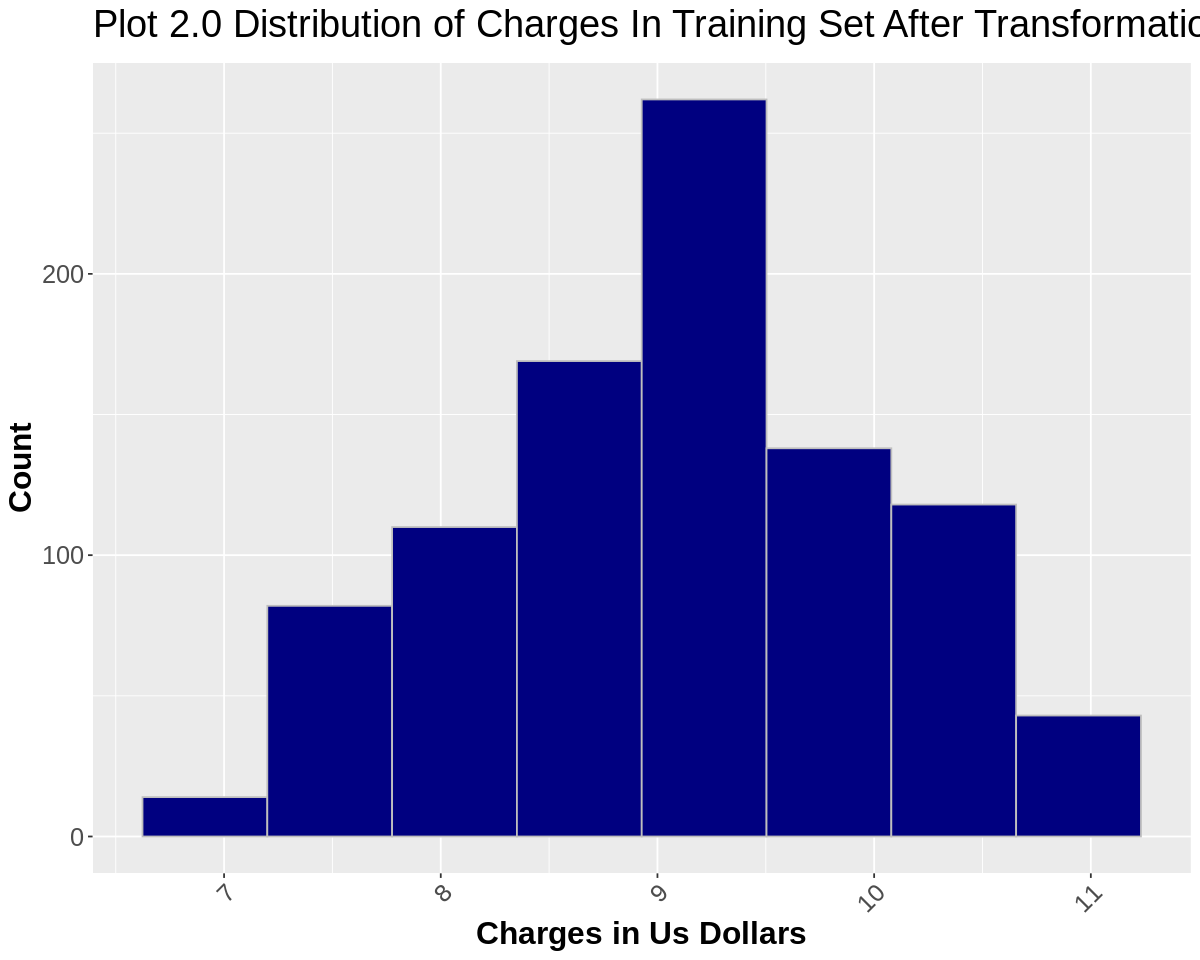

In [70]:
options(repr.plot.width = 10, repr.plot.height = 8)
hist_tran_charges <- ggplot(tran_training_set, aes(x = charges)) +
  geom_histogram(bins = 8, color = "gray", fill = "navyblue") +
  xlab("Charges in Us Dollars") +
  ylab("Count") +
  theme(
    text = element_text(size = 19),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold"),
    axis.text.x = element_text(angle = 45, hjust = 1)
  )+ 
  ggtitle(expression("Plot 2.0 Distribution of Charges In Training Set After Transformation"))
hist_tran_charges

From the plot above, the distribution of our transferred target variable is more Normally distributed.

We plan to use LASSO(3) to fit a linear regression to predict the charges someone might have to pay given different parameters. When finding the best lasso model, we will use a 10 fold cross validation to pick the lambda that minimizes the root mean squared error (RMSE). We will also fit a ridge model, an ordinary least squares model, and a k-nearest neighbors model to compare the performance of our chosen model. We won't be trying to find the best model in this step since this would result in bias from us choosing the model from the performance on the training set, and would make the predicted error not representative of the real error me might find.

#### 3. Model Selection by using Lasso

10 fold cross-validation is carried out to find the best model

Code Reference: <br>
https://stats.stackexchange.com/questions/72251/an-example-lasso-regression-using-glmnet-for-binary-outcome

In [71]:
set.seed(1234)
x_train <-model.matrix(tran_training_set$charges~tran_training_set$age+tran_training_set$sex+tran_training_set$bmi+tran_training_set$children+tran_training_set$smoker+tran_training_set$region)[,-1]
lasso_model = cv.glmnet(x=x_train,y =tran_training_set$charges,alpha=1, nfolds=10)
lasso_model


Call:  cv.glmnet(x = x_train, y = tran_training_set$charges, nfolds = 10,      alpha = 1) 

Measure: Mean-Squared Error 

     Lambda Index Measure      SE Nonzero
min 0.00133    67  0.2115 0.01199       8
1se 0.04569    29  0.2234 0.01351       4

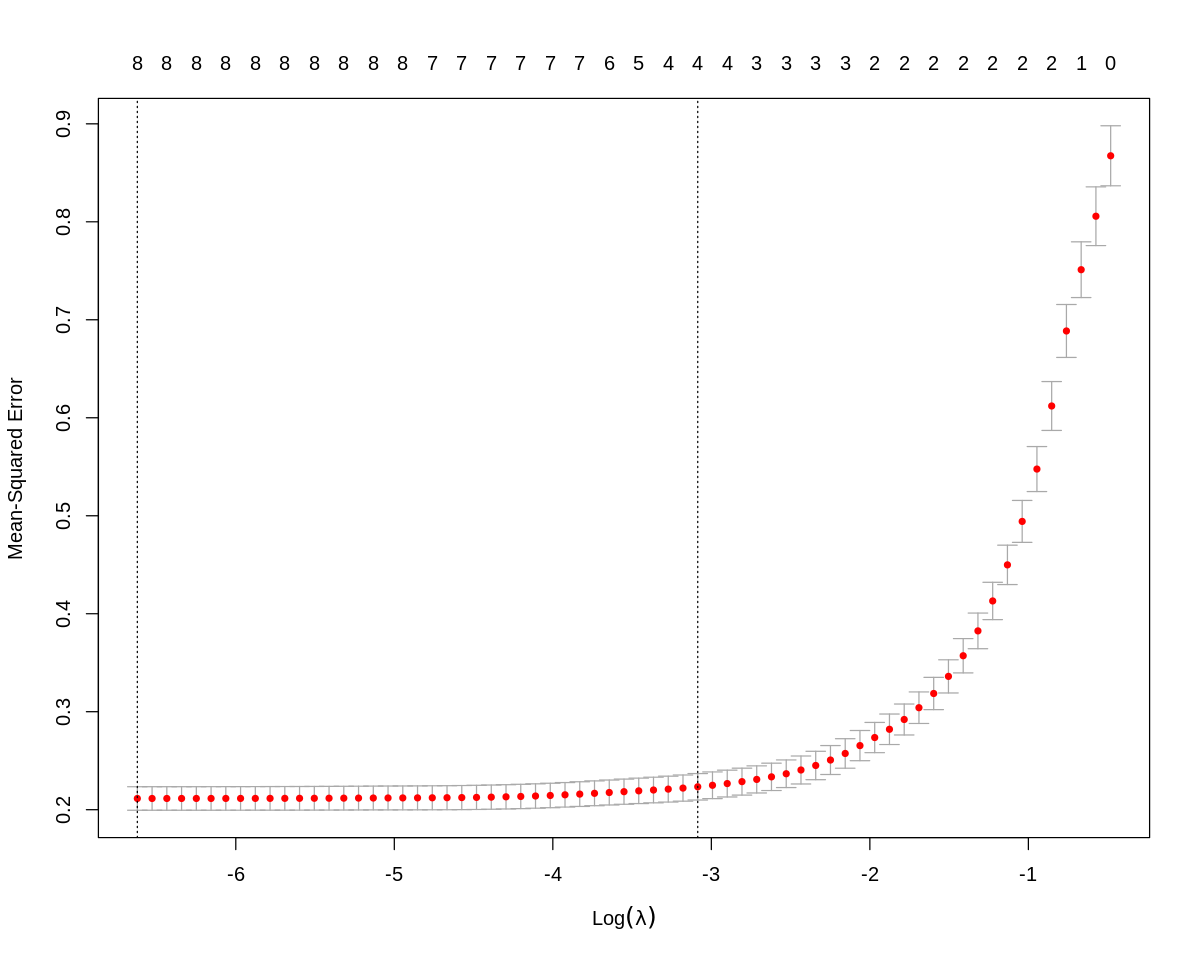

In [72]:
plot(lasso_model)

The LASSO model has shrinked the variables to 4 with the minimized lambda.

In [73]:
best_lambda <- lasso_model$lambda.min
best_lambda

[1] 0.001331958

Making a new Lasso model with the minimized lambda

In [74]:
best_model<-glmnet(x=x_train,y =tran_training_set$charges,alpha=1, lambda=best_lambda)

In [75]:
set.seed(1234) # do not change this
beta_lasso<-lasso_model%>%coef(s = best_lambda)
beta_lasso

9 x 1 sparse Matrix of class "dgCMatrix"
                                    s1
(Intercept)                 7.05186513
tran_training_set$age       0.03453083
tran_training_set$sex1     -0.06464285
tran_training_set$bmi       0.01251814
tran_training_set$children  0.10935674
tran_training_set$smoker1   1.57937243
tran_training_set$region1  -0.04909121
tran_training_set$region2  -0.17126784
tran_training_set$region3  -0.12046990

According to LASSO model, smoker seems to have the highest impact on medical charges, compared with age, bmi, and children. Smoking is detrimental to health, meaning smokers are more likely to have health issues than nonsmokers, which, in turn, leads to increased medical expenses. It also indicates that older people and people with high BMI will have higher medical expenses. Also, it has been observed that those with children incur higher costs, since parents must care for the health of all of their children, as opposed to those who have no children. However, the factors of sex and region do not have as high impact as the factors of smoker, age, bmi, and children on medical charges.

In [76]:
# tidy the model to a more readable formet
best_model


Call:  glmnet(x = x_train, y = tran_training_set$charges, alpha = 1,      lambda = best_lambda) 

  Df  %Dev   Lambda
1  8 76.08 0.001332

In [77]:
summary(best_model)

          Length Class     Mode   
a0        1      -none-    numeric
beta      8      dgCMatrix S4     
df        1      -none-    numeric
dim       2      -none-    numeric
lambda    1      -none-    numeric
dev.ratio 1      -none-    numeric
nulldev   1      -none-    numeric
npasses   1      -none-    numeric
jerr      1      -none-    numeric
offset    1      -none-    logical
call      5      -none-    call   
nobs      1      -none-    numeric

#### 4. Assumptions of Linear Regression models

From the leture in week 6, we know that 4 assumptions are needed when using a Linear Regression model:
1. The response and input variables must be linearly related
2. Errors are independent and identically distributed
3. Conditional distribution of the error terms is Normal
4. No Mulitcollinearity (input variables must have minimal correlation)

So next we will check if our LASSO model satisfies these 4 assumptions.

**4.1 The response and input variables must be linearly related**

We are assuming the relationship is linear.

**4.2 Errors are independent and identically distributed**

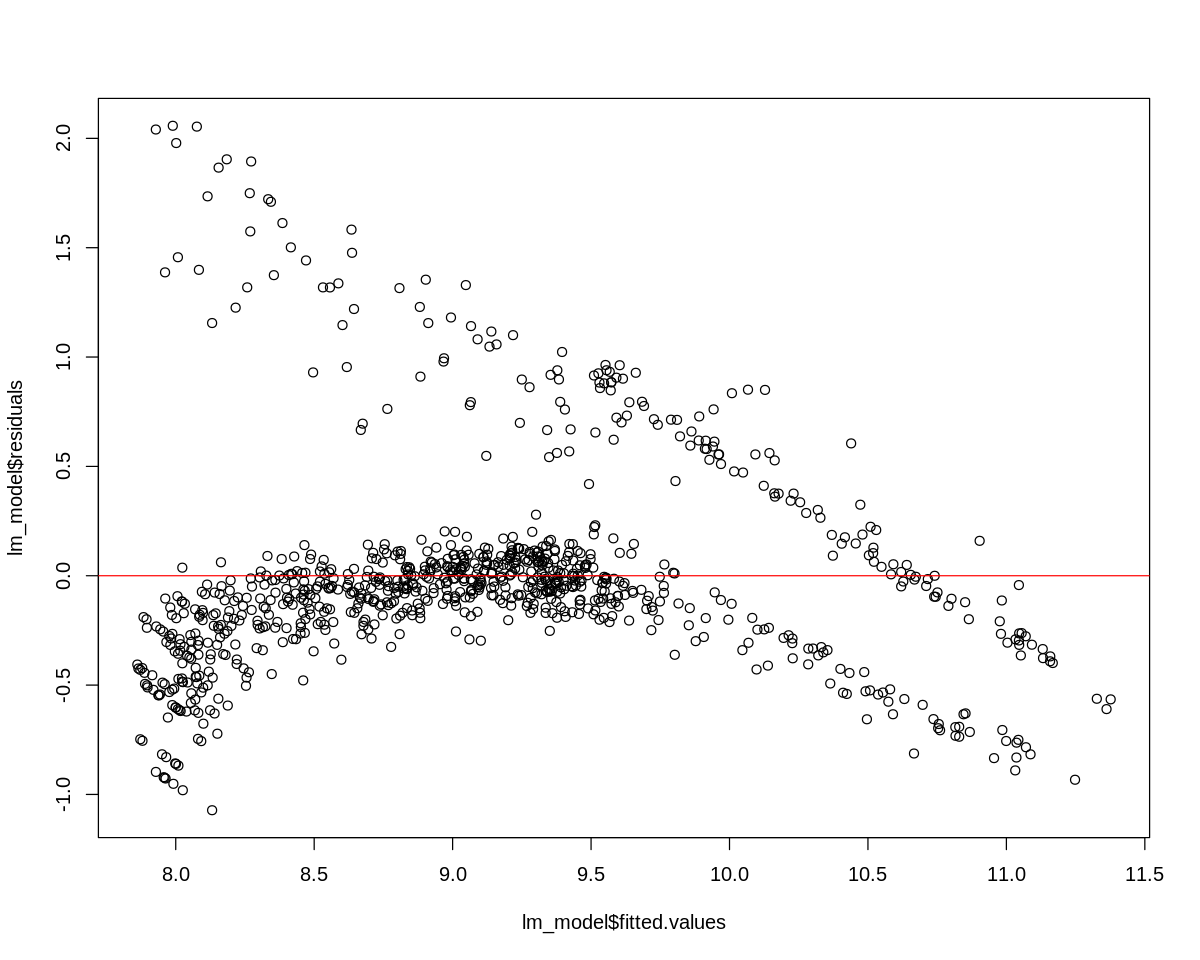

In [78]:
lm_model <- lm(formula = charges ~ age + bmi + children + smoker, data = tran_training_set)
plot(lm_model$fitted.values, lm_model$residuals)
abline(h=0, col = "red")

The diagnostic plot does exhibit a rough funnel shape, which is an indicator of heteroscedasticity. We will continue to assume that the variance is constant and thus the errors are independent and identically distributed. However, the issue of the validity of this assumption may negatively affect our model's accuracy.

**4.3 Conditional distribution of the error terms is Normal**

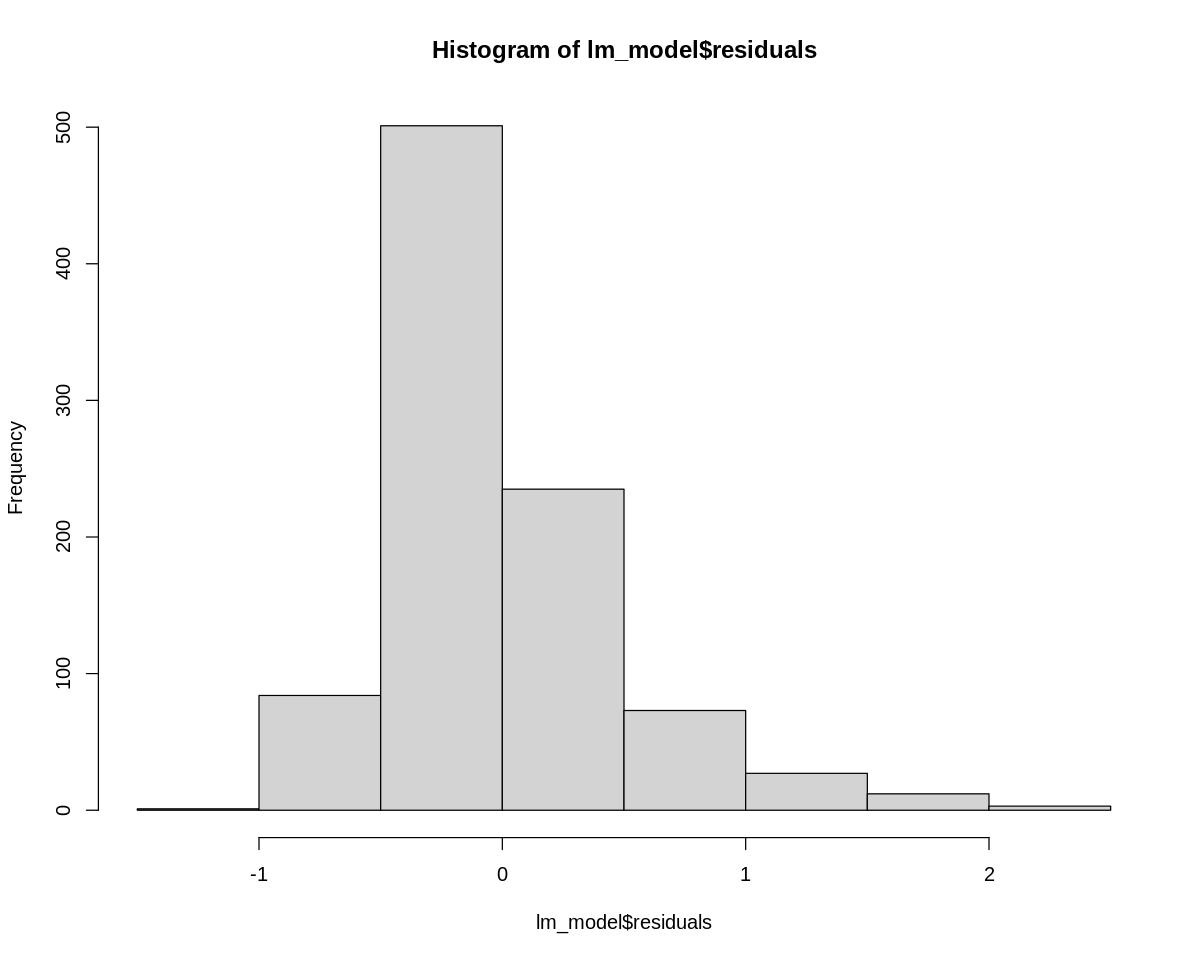

In [79]:
hist(lm_model$residuals)

This histogram shows a right skewed distribution, which does not exactly follow our assumption of Normally distributed errors. We will continue to assume the errors are Normally distributed; however, the issue of the validity of this assumption may negatively affect the accuracy of our model.

**4.4 No Mulitcollinearity**

In [80]:
variables_vif<-vif(lm(tran_training_set$charges ~.,tran_training_set))
variables_vif

,GVIF,Df,GVIF^(1/(2*Df))
age,1.019606,1,1.009755
sex,1.014185,1,1.007068
bmi,1.162409,1,1.078151
children,1.012593,1,1.006277
smoker,1.014577,1,1.007262
region,1.156721,3,1.024562


We use the Variance Inflation Factor (VIF) to measure the effect of multicollinearity in our model. In general, VIF < 10 indicates no multicollinearity occurred among predictors. In our case, the `lasso_variables_vif` clearly does not indicate a very concerning presence of multicollinearity. 

#### 5. Predict on testing set

**5.1 feature transformation on testing set**

In [81]:
testing_set%>%head(3)

,age,sex,bmi,children,smoker,region,charges,ID
,<int>,<chr>,<dbl>,<int>,<chr>,<chr>,<dbl>,<int>
1,28,male,33.00,3,no,southeast,4449.462,3
2,32,male,28.88,0,no,northwest,3866.855,5
3,37,female,27.74,3,no,northwest,7281.506,8


As we did for training set, a `log-transformation` is also performed to all the numeric variables, and categorical variables are transformed to a binary representation. 

In [82]:
testing_set=testing_set[-8]


tran_testing_set<- testing_set %>% mutate(sex = factor(sex),
                                            smoker = factor(smoker),
                                            region = factor(region),
                                            charges = log(charges),
                                           )

# 0 for female and 1 for male
levels(tran_testing_set$sex) <- c(0,1)

# 1 for yes and 0 for no
levels(tran_testing_set$smoker) <- c(0,1)

# northeast = 0, northwest = 1,southeast = 2, southwest = 3, 
levels(tran_testing_set$region) <- c(0,1,2,3)


In [83]:
x_test <-model.matrix(tran_testing_set$charges~tran_testing_set$age+tran_testing_set$sex+tran_testing_set$bmi+tran_testing_set$children+tran_testing_set$smoker+tran_testing_set$region)[,-1]

predictions<- predict(best_model, newx = x_test, s = "lambda.min")

x_test%>%head(3)

,tran_testing_set$age,tran_testing_set$sex1,tran_testing_set$bmi,tran_testing_set$children,tran_testing_set$smoker1,tran_testing_set$region1,tran_testing_set$region2,tran_testing_set$region3
1,28,1,33.00,3,0,0,1,0
2,32,1,28.88,0,0,1,0,0
3,37,0,27.74,3,0,1,0,0


In [84]:
actual = tran_testing_set$charges
prediction = predictions
rmse_lasso<- rmse(actual,prediction)
rmse_lasso

[1] 0.4129776

#### 6. Ridge for comparison


Call:  cv.glmnet(x = x_train, y = tran_training_set$charges, nfolds = 10,      alpha = 0) 

Measure: Mean-Squared Error 

     Lambda Index Measure      SE Nonzero
min 0.06182   100  0.2140 0.01149       8
1se 0.14282    91  0.2235 0.01146       8

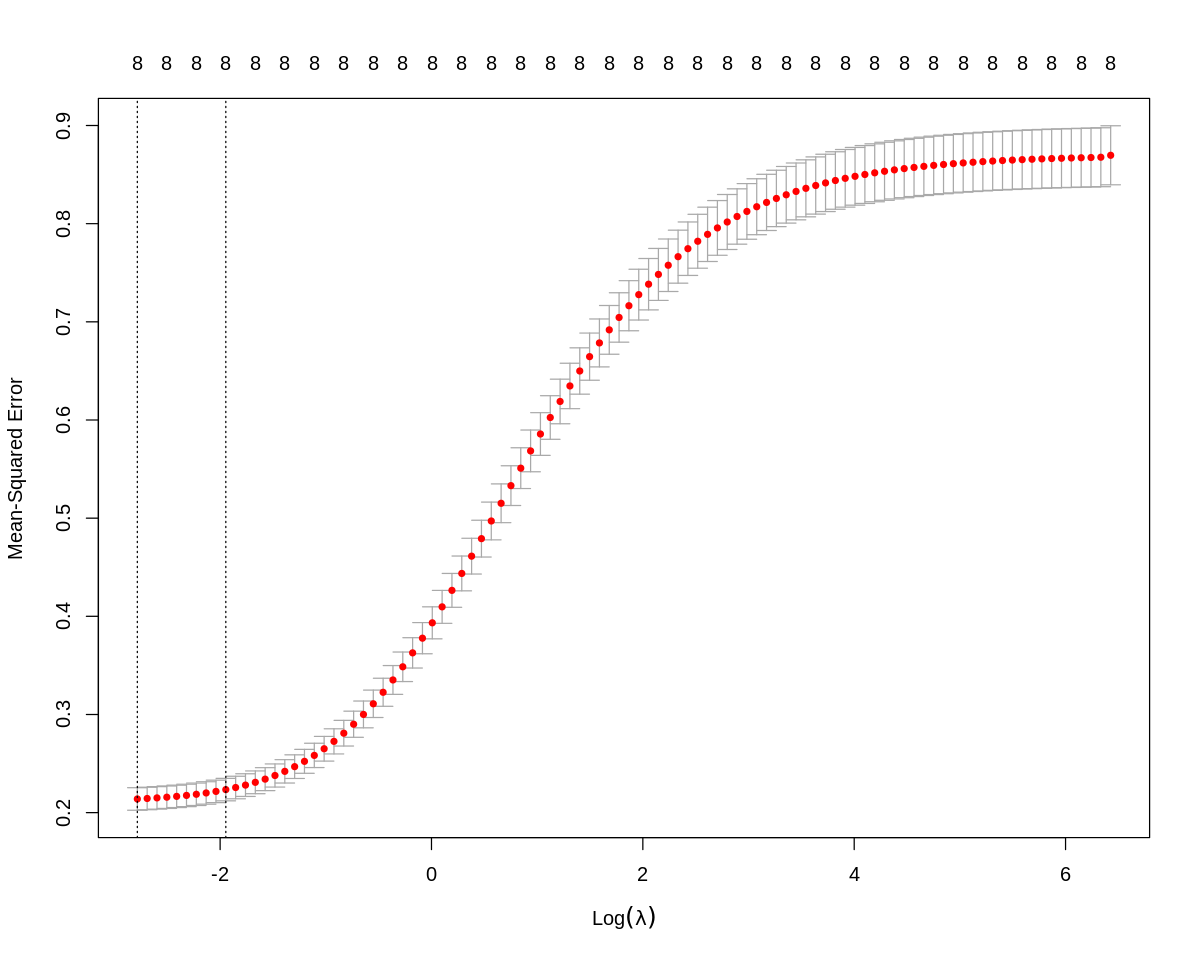

In [85]:
# ridge
set.seed(1234)
ridge_model = cv.glmnet(x=x_train,y =tran_training_set$charges,alpha=0, nfolds=10)
ridge_model
plot(ridge_model)

In [86]:
best_lambda_ridge <- ridge_model$lambda.min
best_lambda_ridge

[1] 0.06182403

In [87]:
best_model_ridge<-glmnet(x=x_train,y =tran_training_set$charges,alpha=0, lambda=best_lambda_ridge)

In [88]:
prediction_ridge <- predict(best_model_ridge, newx = x_test, s = "lambda.min")

In [89]:
actual = tran_testing_set$charges
prediction = prediction_ridge

rmse_ridge<- rmse(actual,prediction)

In [90]:
length(actual)
length(prediction)

[1] 402

[1] 402

In [91]:
# VS lasso : 0.412977596985591-> comment
# https://stats.stackexchange.com/questions/331782/if-only-prediction-is-of-interest-why-use-lasso-over-ridge/331809#331809
# https://stats.stackexchange.com/questions/357413/why-lasso-yield-a-higher-mse-then-ridge


#### 7. OLR for comparison

In [98]:
ols_model<- glmnet(
        x=x_train,
        y =tran_training_set$charges,
        alpha = 0,
        lambda = 0)
ols_model


Call:  glmnet(x = x_train, y = tran_training_set$charges, alpha = 0,      lambda = 0) 

  Df  %Dev Lambda
1  8 76.08      0

In [99]:
prediction_ols<- predict(ols_model, newx = x_test)

actual = tran_testing_set$charges
prediction = prediction_ols

rmse_ols<-rmse(actual,prediction)
rmse_ols

[1] 0.4132321

#### 8. KNN for comparison

In [94]:
# reference: https://cran.r-project.org/web/packages/caret/caret.pdf

In [95]:
knn_model_7 = knnreg(x_train, tran_training_set$charges, k = 7)
pred_knn_7 = predict(knn_model_7, x_test)

rmse_knn_7 = rmse(tran_testing_set$charges, pred_knn_7 )
rmse_knn_7

[1] 0.7377994

In [96]:
knn_model_3 = knnreg(x_train, tran_training_set$charges, k = 3)
pred_knn_3 = predict(knn_model_3, x_test)

rmse_knn_3 = rmse(tran_testing_set$charges, pred_knn_3)
rmse_knn_3

[1] 0.7948263

#### 9. RMSE Summary Table

In [101]:
RMSE_results <- 
    tibble(
        model = c("OLS", "ridge","LASSO", "KNN-3", "KNN-7"),
        rmse = c(rmse_ols,rmse_ridge,rmse_lasso,rmse_knn_3,rmse_knn_7) )

RMSE_results 

model,rmse
<chr>,<dbl>
OLS,0.4132321
ridge,0.4119294
LASSO,0.4129776
KNN-3,0.7948263
KNN-7,0.7377994


## Discussion

From the RMSE Summary table above, we can see that the ordinary least squares model, LASSO model, and ridge model have similar RMSEs. These three models have vastly outperformed the KNN models, which have a much higher RMSE. The model with the lowest RMSE is actually the ridge model and not our LASSO model. However, this is expected: LASSO removes covariates by reducing coefficients to zero, while ridge does not. As a result, while the ridge model has a lower RMSE, the model is more complicated as a result of containing more covariates. The extra covariates will also lead to increased variance in our predictions. The difference between the RMSEs of the ridge model and LASSO model is very minimal (about 0.001). This small decrease in RMSE is not worth the increased complexity of the ridge model and the increased variance of the predictions. Thus, practically speaking, our LASSO model is the best of the models compared.

Probably the best way to improve our model would be to have more data, as our dataset only had about 1300 rows. Having more data would give us a better picture of the trends of insurance prices. In particular, if we could get very recent data, it would be better for predicting trends in the near future, since the external factors would be similar. Having more data and very recent data can minimize the risk of there being confounding variables that can affect the relationship between the response and the covariates. There is also the concern of the assumptions of a Linear Regression, namely the IID assumption (4.2) and the Normally distributed errors assumption (4.3). Often there is not much we can do about these issues since they are inherent to the data (which is a reflection of the real world climate), but these should be noted as potential sources of error.

A further issue that can be considered is additional response variables. Some examples are whether or not a family has a member with underlying health conditions, whether or not the primary beneficiary is an alcoholic, or the industry the primary beneficiary works in. It could also be interesting to perform the same analysis on data from another country, and do a comparison of the significant factors.

## References

(1) Mohamed Hanafy (2021) Predict Health Insurance Cost by using Machine Learning and DNN Regression Models. International Journal of Innovative Technology and Exploring Engineering Volume-10(Issue-3):137. DOI:10.35940/ijitee.C8364.0110321

(2) Ray M Merrill, Rylan Fowers (2019) To what extent does sex, age and BMI impact medical and pharmacy costs? A retrospective cohort study involving employees in a large school district in the USA. BMJ Open 28;9(5):e024078. doi: 10.1136/bmjopen-2018-024078.

(3) Tibshirani, R. (1996), Regression Shrinkage and Selection Via the Lasso. Journal of the Royal Statistical Society: Series B (Methodological), 58: 267-288. https://doi.org/10.1111/j.2517-6161.1996.tb02080.x
 
(4) FAQ/Collinearity - CBU statistics Wiki. (2015, January). CBU Statistics Wiki. https://imaging.mrc-cbu.cam.ac.uk/statswiki/FAQ/Collinearity